In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import argparse
import segmentation_models_v1 as sm
# from segmentation_models_v1 import Unet, Linknet, PSPNet, FPN, DUNet, BiFPN, Nestnet
sm.set_framework('tf.keras')
from model import U_Net

from helper_function import plot_history
from helper_function import precision, recall, f1_score
from sklearn.metrics import confusion_matrix

In [4]:
def str2bool(value):
    return value.lower() == 'true'

def generate_folder(folder_name):
	if not os.path.exists(folder_name):
		os.system('mkdir -p {}'.format(folder_name))

In [14]:
# parser = argparse.ArgumentParser()
# parser.add_argument("--docker", type=str2bool, default = False)
# parser.add_argument("--gpu", type=str, default = '1')
# parser.add_argument("--net_type", type=str, default = 'U_Net')
# parser.add_argument("--epoch", type=int, default = 2)
# parser.add_argument("--dim", type=int, default = 256)
# parser.add_argument("--batch_size", type=int, default = 2)
# parser.add_argument("--dataset", type=str, default = 'bacterial')
# parser.add_argument("--lr", type=float, default = 1e-4)
# parser.add_argument("--cross", type=int, default = 1)
# parser.add_argument("--loss", type=str, default = 'bce')
# args = parser.parse_args()
# print(args)
docker = False
gpu = '1'
net_type = 'U_Net'
epoch = 2
dim = 256
batch_size = 2
dataset = 'bacterial'
lr = 1e-4
cross = 1
loss = 'bce'

In [16]:
model_name = 'unet-epoch-{}-batch-{}-lr-{}-dim-{}-set-{}-loss-{}-cross-{}'.format(epoch,\
             batch_size, lr, dim, dataset, loss, cross)
print(model_name)

os.environ['CUDA_VISIBLE_DEVICES'] = gpu

if dataset == 'bacterial':
	val_dim = 256; img_dim = 256
elif dataset == 'bone_marrow':
	val_dim = 608; img_dim = 600
elif dataset == 'colorectal':
	val_dim = 512; img_dim = 500
elif dataset == 'hESC':
	val_dim = 512; img_dim = 512

DATA_DIR = '/data/datasets/unet/{}'.format(dataset) if docker else './datasets/unet/{}'.format(dataset)
DATA_DIR = DATA_DIR+'/cross-{}'.format(cross)
x_train_dir = os.path.join(DATA_DIR, 'train', 'images')
y_train_dir = os.path.join(DATA_DIR, 'train', 'masks')

x_valid_dir = os.path.join(DATA_DIR, 'val', 'images')
y_valid_dir = os.path.join(DATA_DIR, 'val', 'masks')


print(x_train_dir); print(x_valid_dir)
# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['bk', 'cell']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None,
            nb_data=None,
            augmentation=None, 
            preprocessing=None,
    ):
        id_list = os.listdir(images_dir)
        if nb_data ==None:
            self.ids = id_list
        else:
            self.ids = id_list[:int(min(nb_data,len(id_list)))]
        #self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        #print(self.images_fps[:4]); print(self.masks_fps[:4])
        print(len(self.images_fps)); print(len(self.masks_fps))
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
#         print(np.unique(mask))
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
#         print(self.class_values)
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(tf.keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
#         map_batch = batch[1]
#         map_batch_list = [map_batch]
#         for i in range(4):
#             map_batch_list.append(map_batch[:,::2,::2,:])
#             map_batch = map_batch[:,::2,::2,:]
#         map_batch_list.reverse()
#         map_tuple = ()
#         for i in range(5):
#             map_tuple = map_tuple+(map_batch_list[i],)
        return (batch[0], batch[1])
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

import albumentations as A

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation(dim = 256, rot_limit = 45):
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=rot_limit, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=dim, min_width=dim, always_apply=True, border_mode=0),
        A.RandomCrop(height=dim, width=dim, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation(dim = 256):
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(dim, dim),
        A.RandomCrop(height=dim, width=dim, always_apply=True)
#         A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)


# BACKBONE = 'efficientnetb3'
BATCH_SIZE = batch_size
CLASSES = ['cell']
LR =lr
EPOCHS = epoch

# preprocess_input = sm.get_preprocessing(BACKBONE)

# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
# activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
net_func = globals()[net_type]

# encoder_weights='imagenet' if args.pre_train else None
model = net_func(None, None, color_type = 3, num_class =n_classes)

# model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

# define optomizer
optim = tf.keras.optimizers.Adam(LR)

# class_weights = [1,1,1,0.5]
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
# if args.loss =='focal+dice':
# 	dice_loss = sm.losses.DiceLoss(class_weights=np.array(class_weights))
# 	focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
# 	total_loss = dice_loss + (1 * focal_loss)
# elif args.loss =='dice':
# 	total_loss = sm.losses.DiceLoss(class_weights=np.array(class_weights))
# elif args.loss =='jaccard':
# 	total_loss = sm.losses.JaccardLoss(class_weights=np.array(class_weights))
# elif args.loss =='focal+jaccard':
# 	dice_loss = sm.losses.JaccardLoss(class_weights=np.array(class_weights))
# 	focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
# 	total_loss = dice_loss + (1 * focal_loss)
# elif args.loss =='focal+jaccard+dice':
# 	dice_loss = sm.losses.JaccardLoss(class_weights=np.array(class_weights))
# 	jaccard_loss = sm.losses.JaccardLoss(class_weights=np.array(class_weights))
# 	focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
# 	total_loss = dice_loss + jaccard_loss+ (1 * focal_loss)
total_loss = sm.losses.BinaryFocalLoss()
# 	total_loss = dice_loss + (1 * focal_loss)
# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optimizer=optim, loss=total_loss, metrics = metrics)

# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES,
    augmentation=get_training_augmentation(dim, 0),
    preprocessing=None,
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(val_dim),
    preprocessing=None,
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

print(train_dataloader[0][0].shape)
# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, dim, dim, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, dim, dim, n_classes)

model_folder = '/data/models/unet/{}'.format(model_name) if docker else './models/unet/{}'.format(model_name)
generate_folder(model_folder)


# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(model_folder+'/best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(),
]

# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

# save the training information
plot_history(model_folder+'/train_history.png',history)

# evaluate model
test_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes = CLASSES,
    augmentation=get_validation_augmentation(val_dim),
    preprocessing=None
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)
#model = net_func(BACKBONE, encoder_weights=encoder_weights, input_shape = (test_dim, test_dim, 3), classes=n_classes, activation=activation)
# model.compile(optimizer=optim, loss=total_loss, metrics = metrics)

# load best weights
model.load_weights(model_folder+'/best_model.h5')
scores = model.evaluate_generator(test_dataloader)
print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

# calculate the pixel-level classification performance
pr_masks = model.predict(test_dataloader); pr_maps = 1.0*(pr_masks>0.5).squeeze()
gt_masks = []
for i in range(len(test_dataset)):
    _, gt_mask = test_dataset[i];gt_masks.append(gt_mask)
gt_masks = np.stack(gt_masks); gt_maps = gt_masks.squeeze()

unet-epoch-2-batch-2-lr-0.0001-dim-256-set-bacterial-loss-bce-cross-1
./datasets/unet/bacterial/cross-1/train/images
./datasets/unet/bacterial/cross-1/val/images


/home/sh38/anaconda3/envs/proGAN_tf/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:2029: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn('Using lambda is incompatible with multiprocessing. '


160
160
40
40
(2, 256, 256, 3)
Epoch 1/2
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
80/80 [==============================] - 11s 143ms/step - loss: 0.9440 - iou_score: 1.5249e-04 - f1-score: 3.0418e-04 - val_loss: 0.9824 - val_iou_score: 1.3633e-09 - val_f1-score: 1.3633e-09
Epoch 2/2
80/80 [==============================] - 7s 83ms/step - loss: 0.8435 - iou_score: 4.2153e-06 - f1-score: 8.4285e-06 - val_loss: 0.8789 - val_iou_score: 1.3633e-09 - val_f1-score: 1.3633e-09
40
40
Loss: 0.87895
mean iou_score: 1.3633e-09
mean f1-score: 1.3633e-09


In [17]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    SMALL_SIZE = 24
    MEDIUM_SIZE = 24
    BIGGER_SIZE = 24

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    return ax

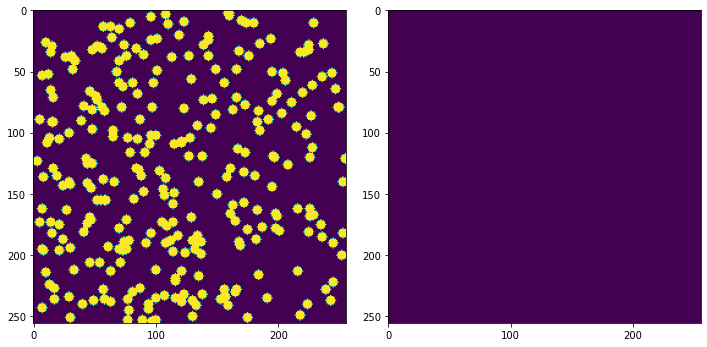

In [18]:
ax = get_ax(rows = 1, cols = 2, size = 5)
ax[0].imshow(gt_maps[0]); ax[1].imshow(pr_maps[0])